# Oze challenge example
## Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import skorch
import torch
from skorch.callbacks import EarlyStopping
from matplotlib import pyplot as plt

from time_series_predictor import TimeSeriesPredictor
from time_series_models import BenchmarkLSTM
from oze_dataset import npz_check, OzeNPZDataset

## Config

In [2]:
plot_config = {}
plot_config['training progress'] = True
plot_config['prediction on training data'] = True
plot_config['forecast'] = True

forecast_config = {}
forecast_config['include history'] = True
forecast_config['steps ahead'] = 500

predictor_config = {}
predictor_config['epochs'] = 300
predictor_config['learning rate'] = 1e-2
predictor_config['hidden dim'] = 100
predictor_config['layers num'] = 3
predictor_config['patience'] = 40
predictor_config['dropout'] = 0 # 0.2
predictor_config['train shuffle'] = True
predictor_config['weight decay'] = 0 # 1E-5
predictor_config['bidirectional'] = False # True
predictor_config['train split'] = 20

config = {}
config['plot'] = plot_config
config['forecast'] = forecast_config
config['predictor'] = predictor_config
config['predict on training data enabled'] = True
config['forecast enabled'] = True

## Time Series Predictor instantiation

In [3]:
tsp = TimeSeriesPredictor(
    BenchmarkLSTM(
        hidden_dim=config['predictor']['hidden dim'],
        num_layers=config['predictor']['layers num'],
        dropout = config['predictor']['dropout'],
        bidirectional=config['predictor']['bidirectional']
    ),
    # Shuffle training data on each epoch
    iterator_train__shuffle=config['predictor']['train shuffle'],
    optimizer__weight_decay=config['predictor']['weight decay'],
    early_stopping=EarlyStopping(patience=config['predictor']['patience']),
    lr=config['predictor']['learning rate'],
    max_epochs=config['predictor']['epochs'],
    train_split=skorch.dataset.CVSplit(config['predictor']['train split']),
    optimizer=torch.optim.Adam
)

## Training process

In [4]:
credentials = {'user_name': os.environ.get('CHALLENGE_USER_NAME'), 'user_password': os.environ.get('CHALLENGE_USER_PASSWORD')}
ds = OzeNPZDataset(
    dataset_path=npz_check(
        Path(os.path.abspath(''), 'datasets'),
        'dataset',
        credentials=credentials
    )
)
tsp.fit(ds)


Using device cuda
Re-initializing module because the following parameters were re-set: input_dim, output_dim.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.0726        0.0178     +  16.8168
      2        0.0163        0.0151     +  16.5979
      3        0.0131        0.0135     +  17.0054
      4        0.0107        0.0113     +  17.0106
      5        0.0079        0.0065     +  17.5467
      6        0.0062        0.0056     +  17.5649
      7        0.0052        0.0047     +  17.6946
      8        0.0045        0.0118        17.8361
      9        0.0067        0.0042     +  17.8920
     10        0.0041        0.0039     +  17.8906
     11        0.0037        0.0036     +  17.8662
     12        0.0034        0.0033     +  17.9538
     13        0.0034        0.0033     +  18.3617
     14        0.0033        0.0034        18.2860
     15        0.0032        0.0031     +  18.2

### Plot training evolution

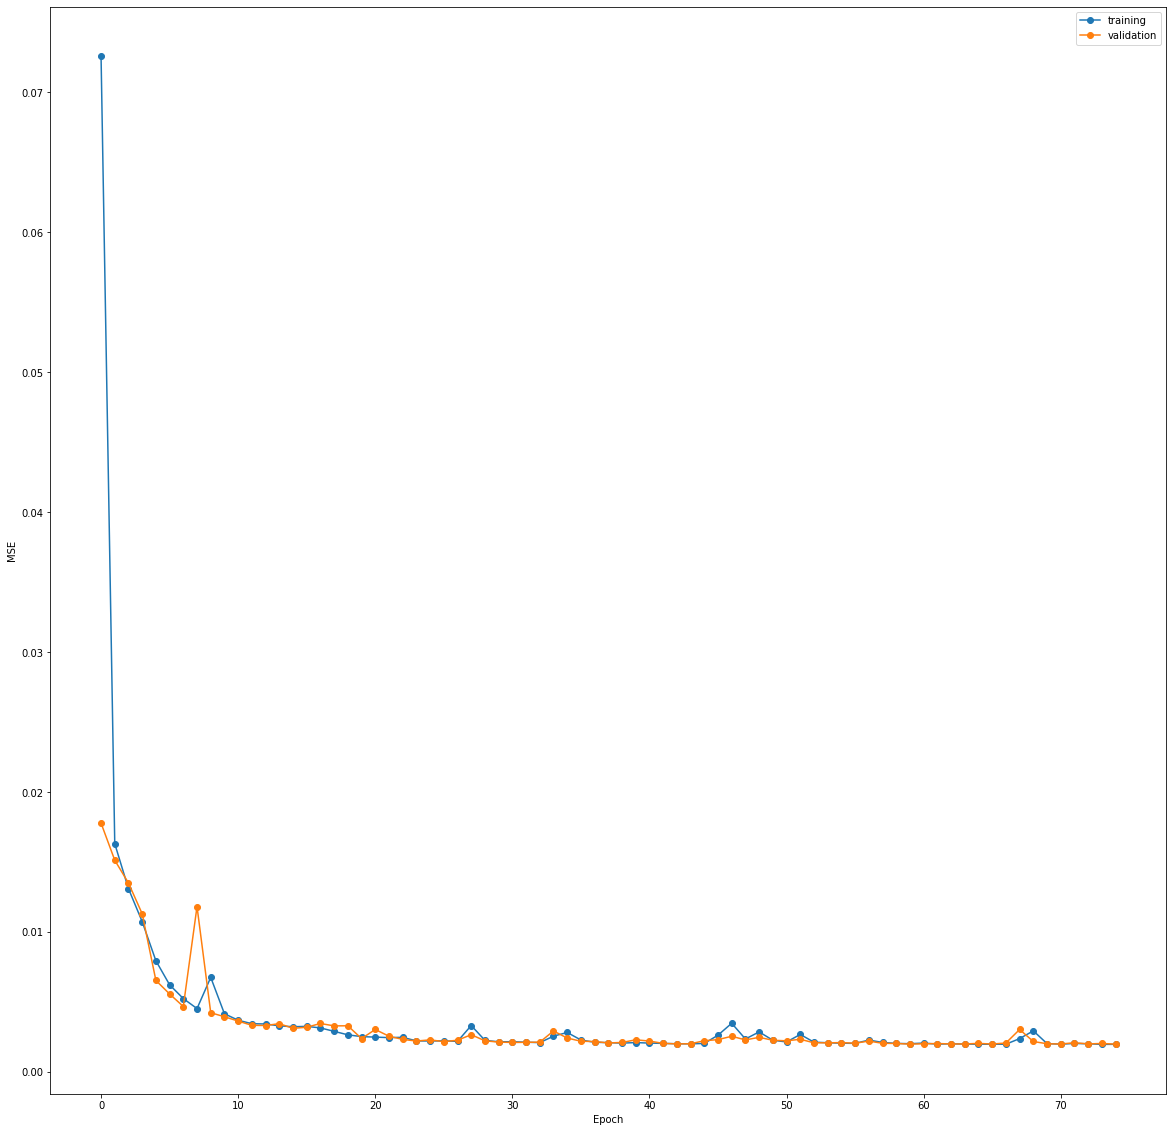

In [5]:
if config['plot']['training progress']:
    history_length = len(tsp.ttr.regressor_['regressor'].history)
    train_loss = np.zeros((history_length, 1))
    valid_loss = np.zeros((history_length, 1))
    for epoch in tsp.ttr.regressor_['regressor'].history:
        epoch_number = epoch['epoch']-1
        train_loss[epoch_number] = epoch['train_loss']
        valid_loss[epoch_number] = epoch['valid_loss']
    _, axes_one = plt.subplots(figsize=(20, 20))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    axes_one.set_xlabel('Epoch')
    axes_one.set_ylabel('MSE')
    plt.legend()

## Prediction on training data

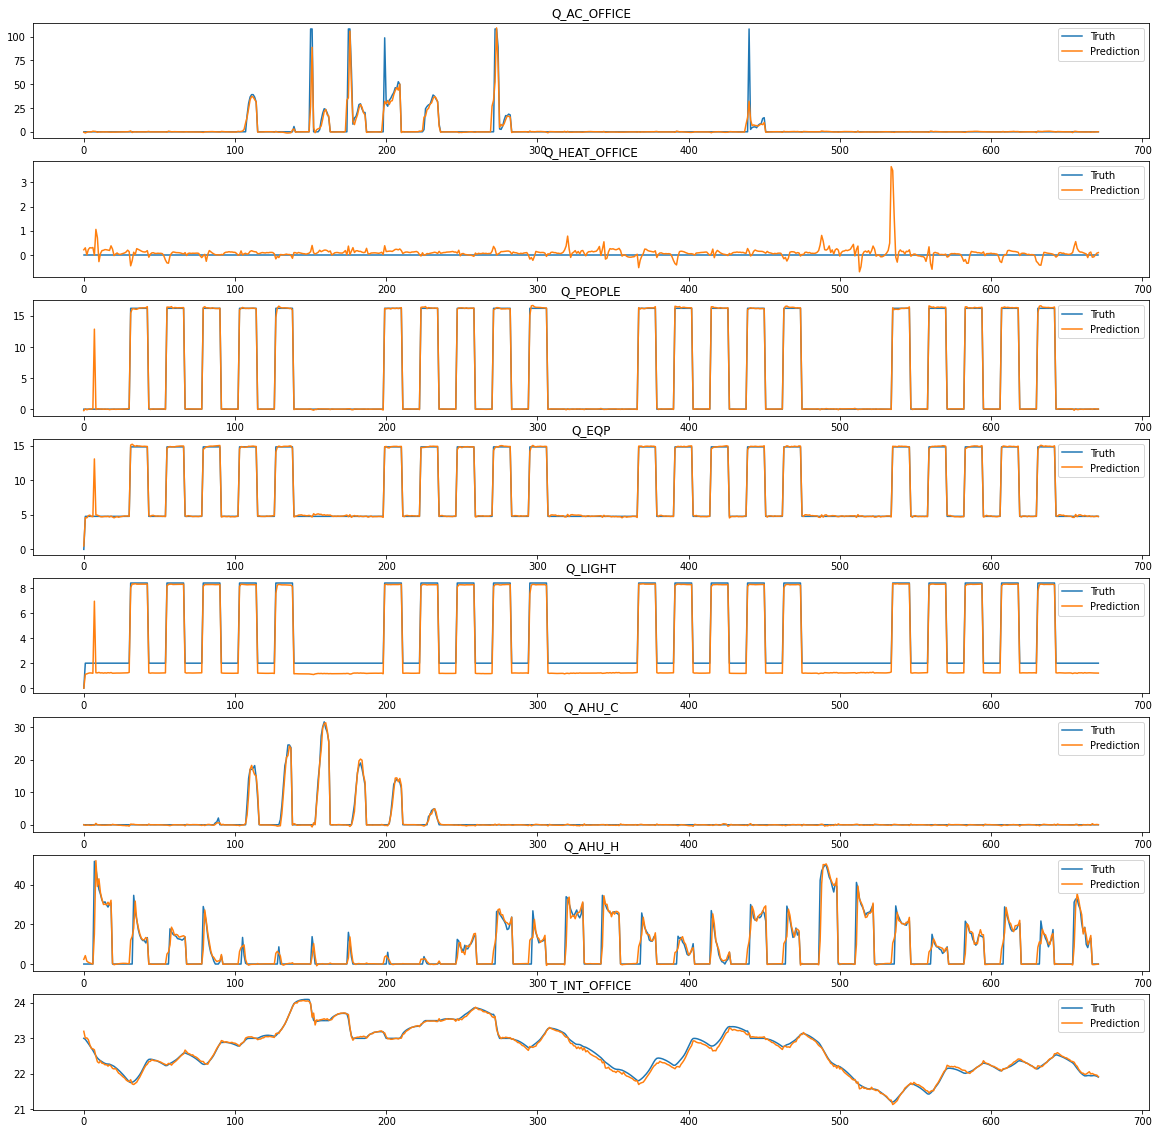

In [6]:
if config['predict on training data enabled']:
    # Select training example
    idx = np.random.randint(0, len(tsp.dataset))
    dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
    x, y = dataloader.dataset[idx]

    # Run predictions
    netout = tsp.sample_predict(x)

    d_output = netout.shape[1]
    if config['plot']['prediction on training data']:
        fig, axs = plt.subplots(d_output, 1, figsize=(20,20))
    for idx_output_var in range(d_output):
        ax = axs[idx_output_var]
        # Select real passengers data
        y_true = y[:, idx_output_var]

        y_pred = netout[:, idx_output_var]

        if config['plot']['prediction on training data']:
            ax.plot(y_true, label="Truth")
            ax.plot(y_pred, label="Prediction")
            ax.set_title(tsp.dataset.labels['X'][idx_output_var])
            ax.legend()

## Future forecast

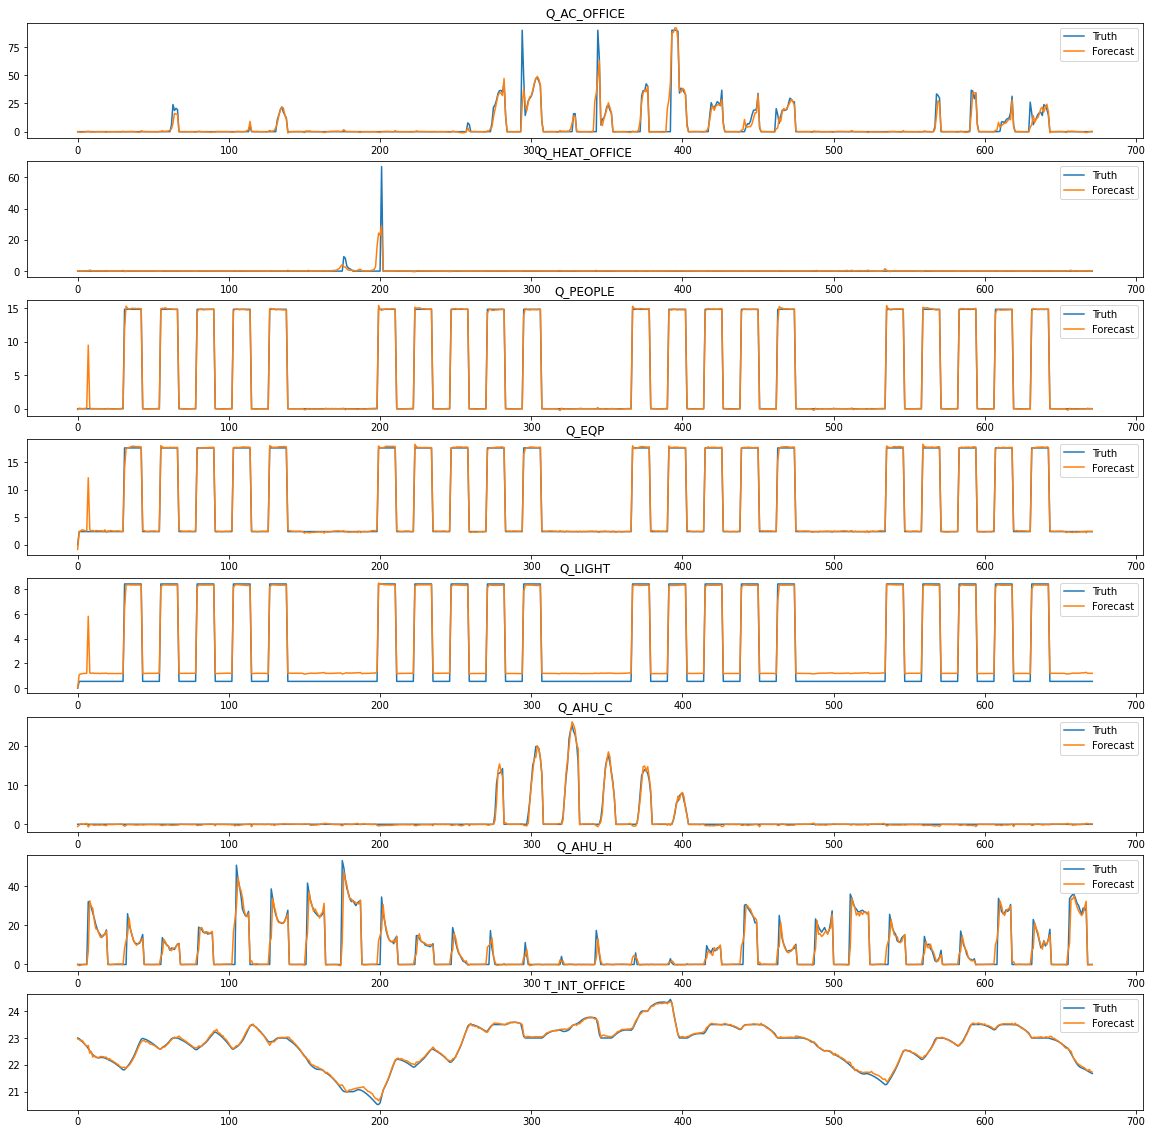

In [7]:
# Run forecast
if config['forecast enabled']:
    netout, _ = tsp.forecast(config['forecast']['steps ahead'],
                          include_history=config['forecast']['include history'])

    d_output = netout.shape[-1]
    # Select any training example just for comparison
    idx = np.random.randint(0, len(ds))
    dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
    x, y = dataloader.dataset[idx]
    if config['plot']['forecast']:
        fig, axs = plt.subplots(d_output, 1, figsize=(20,20))
    for idx_output_var in range(d_output):
        # Select real passengers data
        y_true = y[:, idx_output_var]

        y_pred = netout[idx, :, idx_output_var]

        if config['plot']['forecast']:
            ax = axs[idx_output_var]
            if config['forecast']['include history']:
                plot_args = [y_pred]
            else:
                y_pred_index = [i+tsp.dataset.get_x_shape()[1]+1 for i in range(len(y_pred))]
                plot_args = [y_pred_index, y_pred]
            ax.plot(y_true, label="Truth")
            ax.plot(*plot_args, label="Forecast")
            ax.set_title(tsp.dataset.labels['X'][idx_output_var])
            ax.legend()